# Notebook to train CNNs

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.amp import GradScaler
import os
import matplotlib.pyplot as plt
import random
import numpy as np
import pandas as pd
import time
from pathlib import Path
from sklearn.metrics import balanced_accuracy_score, f1_score, matthews_corrcoef, roc_auc_score, accuracy_score, recall_score
from data_utils_torch import get_paths_and_labels, calculate_min_max, create_dataloader, extract_subject_id
from plotting_utils_torch import view_image, view_random_image, plot_loss_curves, make_confusion_matrix, view_image_data
from sklearn.model_selection import StratifiedGroupKFold
import gc
from tqdm.auto import tqdm
from monai.networks.nets import ResNet

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Set random seed for reproducibility    
seed = 10
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)

# Set mixed precision     
USE_AMP = True if device.type == 'cuda' else False
scaler = GradScaler(enabled=USE_AMP)
print(f"Automatic Mixed Precision (AMP) enabled: {USE_AMP}")

/home/diogommiranda/tese/ml/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-05-07 19:00:16.507327: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-07 19:00:19.878795: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Using device: cuda
Automatic Mixed Precision (AMP) enabled: True


In [3]:
NORMALIZATION = "mni_reg_CV" # Choose intensity normalization method: "minmax"
DATASET = "smci_pmci" # Choose dataset: "smci_pmci" or "nc_ad"
DATA_DIR = Path("/home/diogommiranda/tese/datasets/") / NORMALIZATION / DATASET
VOLUME_SHAPE = (91, 109, 91) # Expected volume shape of the PET images
BATCH_SIZE = 4 # Set batch size

USE_MASK = False # Set to True to use the ROI mask, False to use the whole brain

if USE_MASK:
    ROI_MASK_PATH = str(Path("/home/diogommiranda/tese/masks/ROI_MASK.nii"))
else:
    ROI_MASK_PATH = None

# Get train paths and labels to calculate minmax values
train_paths, train_labels, class_map = get_paths_and_labels(DATA_DIR, 'train')
train_paths = np.array(train_paths)
train_labels = np.array(train_labels)

# Calculate minmax values for train set
minmax_min, minmax_max = calculate_min_max(train_paths)

# Create train dataset
train_data = create_dataloader(
    paths=train_paths,
    labels=train_labels,
    batch_size=BATCH_SIZE,
    volume_shape=VOLUME_SHAPE,
    is_training=True,
    seed=seed,
    min_val=minmax_min, 
    max_val=minmax_max, 
    mask_path=ROI_MASK_PATH
    )

# Create test set with the minmax values from train
test_paths, test_labels, _ = get_paths_and_labels(DATA_DIR, 'test', class_map=class_map)
test_data = create_dataloader(
    paths=test_paths,
    labels=test_labels,
    batch_size=BATCH_SIZE,
    volume_shape=VOLUME_SHAPE,
    is_training=False,
    seed=None,
    min_val=minmax_min, 
    max_val=minmax_max,
    mask_path=ROI_MASK_PATH
    )

Class map: {'smci': 0, 'pmci': 1}
Scanning /home/diogommiranda/tese/datasets/mni_reg_CV/smci_pmci/train...
    Found 575 files for class 'smci'
    Found 314 files for class 'pmci'
Calculated Min: -0.35769128799438477, Max: 2.7912356853485107
Class map: {'smci': 0, 'pmci': 1}
Scanning /home/diogommiranda/tese/datasets/mni_reg_CV/smci_pmci/test...
    Found 143 files for class 'smci'
    Found 78 files for class 'pmci'


torch.Size([1, 91, 109, 91])


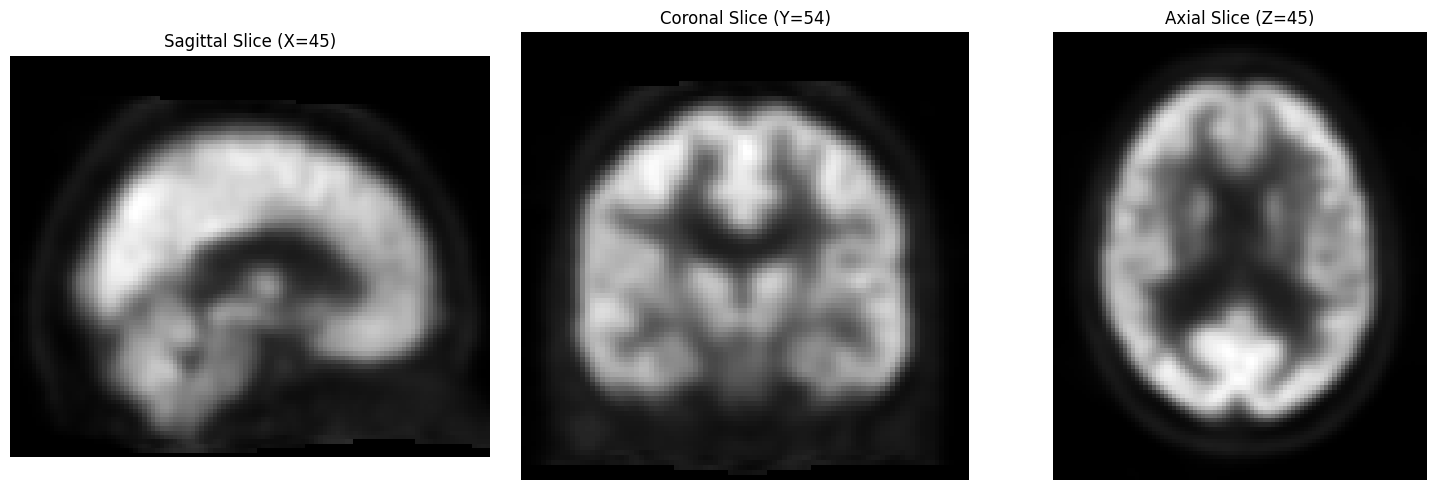

In [3]:
# Verify data with a test sample
i = 2
for data, label in test_data:
    view_image_data(data[i])
    #data[i] = torch.flip(data[i], dims=[3])
    #view_image_data(data[i])
    print(data[i].shape)
    break

In [15]:
# ----- Hyperparameter Tuning with K-Fold Cross-Validation -----

N_SPLITS = 5 # Number of splits for cross-validation

# para cosine decay
#learning_rates = [5e-4, 2e-4, 1e-4] # adicionar 1e-3? ver os resultados
#weight_decays = [5e-4, 2e-4, 1e-4]

#para fixed_lr
#learning_rates = [1e-5, 2e-5] # adicionar 4e-5 ou 5e-6 dependendo dos resultados
#weight_decays = [2e-4, 1e-4] # adicionar 4e-4 ou 5e-5 dependendo dos resultados

lr_scheduler = "cosine_decay" # Choose between "cosine_decay" or "fixed_lr"

if lr_scheduler == "cosine_decay":
    NUM_EPOCHS = 100
    EARLY_STOP_PATIENCE = 40
else:
    NUM_EPOCHS = 60
    EARLY_STOP_PATIENCE = 40

learning_rates = [1e-3] # usar valores a volta do 1e-6 (ate agr a combinacao com l2=1e-4 ou 5e-4 pareceu a melhor com val loss min de 0.24 em 32 epochs)
weight_decays = [1e-4]

tuning_results = []
total_combinations = len(learning_rates) * len(weight_decays)
current_combination_no = 0

if ROI_MASK_PATH is None:
    if lr_scheduler == "cosine_decay":
        RESULTS_BASE_DIR = "/home/diogommiranda/tese/outputs/torch/full_brain/cosine_decay/CROSS_VALIDATION/results_resnet34/"
    elif lr_scheduler == "fixed_lr":
        RESULTS_BASE_DIR = "/home/diogommiranda/tese/outputs/torch/full_brain/fixed_lr/CROSS_VALIDATION/results_resnet34/"
    else:
        raise ValueError("Invalid string for 'lr_scheduler'. Please set it to 'cosine_decay' or 'fixed_lr'.")
    os.makedirs(RESULTS_BASE_DIR, exist_ok=True)
    print(f"Results will be saved to: {RESULTS_BASE_DIR}")
else:
    if lr_scheduler == "cosine_decay":
        RESULTS_BASE_DIR = "/home/diogommiranda/tese/outputs/torch/masked/cosine_decay/CROSS_VALIDATION/results_resnet34/"
    elif lr_scheduler == "fixed_lr":
        RESULTS_BASE_DIR = "/home/diogommiranda/tese/outputs/torch/masked/fixed_lr/CROSS_VALIDATION/results_resnet34/"
    else:
        raise ValueError("Invalid string for 'lr_scheduler'. Please set it to 'cosine_decay' or 'fixed_lr'.")
    os.makedirs(RESULTS_BASE_DIR, exist_ok=True)
    print(f"Results will be saved to: {RESULTS_BASE_DIR}")

# Set up StratifiedGroupKFold by subjects
sgkf = StratifiedGroupKFold(n_splits=N_SPLITS, shuffle=True, random_state=seed)
subject_ids_list = [extract_subject_id(p) for p in train_paths]
subject_ids = np.array(subject_ids_list)

print("\nStarting Hyperparameter Tuning Grid Search...")
overall_start_time = time.time()

# Hyperparameter tuning loop
for current_lr in learning_rates:
    for current_wd in weight_decays: 
        current_combination_no += 1
        print("=" * 60)
        print(f"Testing Combination {current_combination_no}/{total_combinations}: LR={current_lr:.1e}, WeightDecay={current_wd:.0e}")
        print("=" * 60)
        start_time_combination = time.time()

        combo_dir_name = f"LR0_{current_lr:.1e}_WD_{current_wd:.0e}" 
        combo_results_dir = os.path.join(RESULTS_BASE_DIR, combo_dir_name)
        os.makedirs(combo_results_dir, exist_ok=True)
        print(f"  Saving results for this combo to: {combo_results_dir}")

        current_combo_val_losses = []
        current_combo_val_accuracies = []
        current_combo_val_aucs = []
        current_combo_best_epoch = []

        fold_no = 1

        # K-Fold Cross-Validation
        for train_indices, val_indices in sgkf.split(train_paths, train_labels, groups=subject_ids):
            print("-" * 60)
            print(f"Training Fold {fold_no}/{N_SPLITS} for LR={current_lr:.1e} and WD={current_wd:.0e}...")
            start_time_fold = time.time()

            # Get paths and labels for the current fold
            fold_train_paths = train_paths[train_indices]
            fold_train_labels = train_labels[train_indices]
            fold_val_paths = train_paths[val_indices]
            fold_val_labels = train_labels[val_indices]

            # Verify subject separation
            train_subjects = set(subject_ids[train_indices])
            val_subjects = set(subject_ids[val_indices])
            if not train_subjects.isdisjoint(val_subjects):
                 raise RuntimeError(f"WARNING: Fold {fold_no} has overlapping subjects!")

            print(f"  Train samples: {len(fold_train_paths)}, Validation samples: {len(fold_val_paths)}")

            # Calculate minmax parameters for the current training fold
            fold_min, fold_max = calculate_min_max(fold_train_paths)

            # Create fold train dataset
            fold_train_data = create_dataloader(
                paths=fold_train_paths,
                labels=fold_train_labels,
                batch_size=BATCH_SIZE,
                volume_shape=VOLUME_SHAPE,
                is_training=True, 
                seed=seed,
                min_val=fold_min, 
                max_val=fold_max,
                mask_path=ROI_MASK_PATH
            )
            
            # Create fold validation dataset
            fold_val_data = create_dataloader(
                paths=fold_val_paths,
                labels=fold_val_labels,
                batch_size=BATCH_SIZE,
                volume_shape=VOLUME_SHAPE,
                is_training=False, 
                seed=None,
                min_val=fold_min, 
                max_val=fold_max,
                mask_path=ROI_MASK_PATH
            )

            if fold_train_data is None or fold_val_data is None:
                 raise RuntimeError(f"ERROR: Could not create datasets for fold {fold_no}.")
             
            # Compute class weights for the current fold
            unique_classes, class_counts = np.unique(fold_train_labels, return_counts=True)
            print(f"  Fold train label counts: {dict(zip(unique_classes, class_counts))}")
            pos_weight_val = class_counts[0] / class_counts[1]
            pos_weight_val = torch.tensor([pos_weight_val], device=device)
            print(f"  Calculated pos_weight for BCEWithLogitsLoss: {pos_weight_val.item():.4f}")

            model = ResNet(
                block='basic',
                layers=[3, 4, 6, 3],
                block_inplanes=[64, 128, 256, 512],
                spatial_dims=3,
                n_input_channels=1,
                conv1_t_stride=2,
                num_classes=1,
                shortcut_type='B',
                bias_downsample = False
            )
            model.to(device)

            criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight_val).to(device)
            
            #optimizer = optim.Adam(model.parameters(), lr=current_lr, weight_decay=current_wd)
            #optimizer = optim.Adam(model.parameters(), lr=current_lr, weight_decay=current_wd)
            optimizer = optim.SGD(model.parameters(), lr=current_lr, weight_decay=current_wd, momentum=0.9, nesterov=True)
                        
            scheduler = None
            if lr_scheduler == "cosine_decay":
                print("\nUsing Cosine Annealing LR Scheduler.\n")
                scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=60, eta_min=1e-7)
    
            best_val_loss = float('inf')
            epochs_no_improve = 0
            best_epoch = 0
            best_model_state = None
            stopped_epoch = NUM_EPOCHS 

            # Initialize history for this fold
            history = {'epoch': [], 'train_loss': [], 'train_accuracy': [], 'train_auc': [], 'val_loss': [], 'val_accuracy': [], 'val_auc': []}

            for epoch in tqdm(range(NUM_EPOCHS)):
                epoch_start_time = time.time()
                history['epoch'].append(epoch + 1)

                # Train phase
                model.train()
                running_loss = 0.0
                train_pred_probs = []
                train_targets = []
                
                for i, (inputs, labels) in enumerate(fold_train_data):
                    inputs = inputs.to(device)
                    labels = labels.float().unsqueeze(1).to(device)
                    
                    optimizer.zero_grad()
                    
                    # Mixed precision
                    with torch.autocast(device_type=device.type, dtype=torch.float16, enabled=USE_AMP):
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    scaler.scale(loss).backward()
                    scaler.step(optimizer)
                    scaler.update()

                    running_loss += loss.item() * inputs.size(0)
                    
                    prob_outputs = torch.sigmoid(outputs)
                    train_pred_probs.extend(prob_outputs.detach().cpu().numpy())
                    train_targets.extend(labels.detach().cpu().numpy())
 
                train_targets = np.array(train_targets).flatten()
                train_pred_probs = np.array(train_pred_probs).flatten()
                
                # Calculate training metrics for the epoch
                train_loss = running_loss / len(fold_train_data.dataset)
                train_acc = accuracy_score(train_targets, train_pred_probs >= 0.5)
                train_auc = roc_auc_score(train_targets, train_pred_probs)
                history['train_loss'].append(train_loss)
                history['train_accuracy'].append(train_acc)
                history['train_auc'].append(train_auc)

                # Validation phase
                model.eval()
                val_running_loss = 0.0
                val_pred_probs = []
                val_targets = []

                with torch.inference_mode():
                    for inputs, labels in fold_val_data:
                        inputs = inputs.to(device)
                        labels = labels.float().unsqueeze(1).to(device)

                        # Mixed precision
                        with torch.autocast(device_type=device.type, dtype=torch.float16, enabled=USE_AMP):
                            outputs = model(inputs)
                            loss = criterion(outputs, labels)

                        val_running_loss += loss.item() * inputs.size(0)

                        prob_outputs = torch.sigmoid(outputs)
                        val_pred_probs.extend(prob_outputs.cpu().numpy())
                        val_targets.extend(labels.cpu().numpy())
                        
                val_targets = np.array(val_targets).flatten()
                val_pred_probs = np.array(val_pred_probs).flatten()

                # Calculate validation metrics for the epoch
                val_loss = val_running_loss / len(fold_val_data.dataset)
                val_acc = accuracy_score(val_targets, val_pred_probs >= 0.5)
                val_auc = roc_auc_score(val_targets, val_pred_probs)
                history['val_loss'].append(val_loss)
                history['val_accuracy'].append(val_acc)
                history['val_auc'].append(val_auc)

                # Print Epoch Summary
                epoch_duration = time.time() - epoch_start_time
                print(f"    Epoch {epoch+1}/{NUM_EPOCHS} [{epoch_duration:.2f}s] - "
                      f"Train Loss: {train_loss:.5f}, Train Acc: {train_acc:.5f} | "
                      f"Val Loss: {val_loss:.5f}, Val Acc: {val_acc:.5f}")
                
                if scheduler:
                    scheduler.step()

                # Early stopping check
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    epochs_no_improve = 0
                    # Save the best model state
                    best_model_state = model.state_dict()
                    best_epoch = epoch + 1
                else:
                    epochs_no_improve += 1

                if epochs_no_improve >= EARLY_STOP_PATIENCE:
                    model.load_state_dict(best_model_state)
                    stopped_epoch = epoch + 1
                    print(f"\nEarly stopping triggered. Restoring best model weights from epoch {stopped_epoch - epochs_no_improve}.\n")
                    break
            
            # Restore the best model state if early stopping was not triggered
            if epochs_no_improve < EARLY_STOP_PATIENCE:
                print(f"Training completed for {NUM_EPOCHS} epochs. Restoring best model weights from epoch {best_epoch}.")
                model.load_state_dict(best_model_state)
            
            # Save fold history and plots
            fold_dir = os.path.join(combo_results_dir, f"fold_{fold_no}")
            os.makedirs(fold_dir, exist_ok=True)
            history_df = pd.DataFrame(history)
            history_csv_path = os.path.join(fold_dir, f"history_fold_{fold_no}.csv")
            history_df.to_csv(history_csv_path, index=False)
            plot_loss_curves(history, fold_dir)

            # Evaluate the fold
            best_epoch_index = np.argmin(history['val_loss'])
            best_epoch = best_epoch_index + 1
            val_loss_best = history['val_loss'][best_epoch_index]
            val_accuracy_best = history['val_accuracy'][best_epoch_index]
            val_auc_best = history['val_auc'][best_epoch_index]
            print(f"    Fold {fold_no} - Best Epoch {best_epoch}, Val Loss: {val_loss_best:.4f}, Acc: {val_accuracy_best:.4f}, AUC: {val_auc_best:.4f}")

            # Append results for this fold
            current_combo_val_losses.append(val_loss_best)
            current_combo_val_accuracies.append(val_accuracy_best)
            current_combo_val_aucs.append(val_auc_best)
            current_combo_best_epoch.append(best_epoch)
            
            # Free resources
            del model, optimizer, criterion, scheduler, fold_train_data, fold_val_data, history, history_df, best_model_state
            if device.type == 'cuda':
                torch.cuda.empty_cache() 
            gc.collect() 
            
            end_time_fold = time.time()
            print(f"    Fold {fold_no} finished in {end_time_fold - start_time_fold:.2f} seconds.")
            fold_no += 1

        # Aggregate results across folds
        avg_loss = np.mean(current_combo_val_losses)
        std_loss = np.std(current_combo_val_losses)
        avg_acc = np.mean(current_combo_val_accuracies)
        std_acc = np.std(current_combo_val_accuracies)
        avg_auc = np.mean(current_combo_val_aucs)
        std_auc = np.std(current_combo_val_aucs)

        print("-" * 50)
        print(f"Results for LR={current_lr}, WeightDecay={current_wd} (Across {N_SPLITS} Folds):")
        print(f"  Avg Val Loss: {avg_loss:.4f} +/- {std_loss:.4f}")
        print(f"  Avg Val Acc:  {avg_acc:.4f} +/- {std_acc:.4f}")
        print(f"  Avg Val AUC:  {avg_auc:.4f} +/- {std_auc:.4f}")
        print("-" * 50)

        # Store results
        tuning_results.append({
            'learning_rate': current_lr,
            'weight_decay': current_wd,
            'avg_val_loss': avg_loss,
            'std_val_loss': std_loss,
            'avg_val_accuracy': avg_acc,
            'std_val_accuracy': std_acc,
            'avg_val_auc': avg_auc,
            'std_val_auc': std_auc,
            'individual_losses': [round(loss, 4) for loss in current_combo_val_losses],
            'individual_accuracies': [round(acc, 4) for acc in current_combo_val_accuracies],
            'individual_aucs': [round(auc, 4) for auc in current_combo_val_aucs],
            'best_epoch_per_fold': list(current_combo_best_epoch)
        })

        end_time_combination = time.time()
        print(f"Combination {current_combination_no} finished in {end_time_combination - start_time_combination:.2f} seconds.")
        


Results will be saved to: /home/diogommiranda/tese/outputs/torch/full_brain/cosine_decay/CROSS_VALIDATION/results_resnet34/

Starting Hyperparameter Tuning Grid Search...
Testing Combination 1/1: LR=1.0e-03, WeightDecay=1e-04
  Saving results for this combo to: /home/diogommiranda/tese/outputs/torch/full_brain/cosine_decay/CROSS_VALIDATION/results_resnet34/LR0_1.0e-03_WD_1e-04
------------------------------------------------------------
Training Fold 1/5 for LR=1.0e-03 and WD=1e-04...
  Train samples: 726, Validation samples: 163
Calculated Min: -0.35769128799438477, Max: 2.7912356853485107
  Fold train label counts: {0: 472, 1: 254}
  Calculated pos_weight for BCEWithLogitsLoss: 1.8583

Using Cosine Annealing LR Scheduler.



  1%|          | 1/100 [00:08<13:47,  8.36s/it]

    Epoch 1/100 [8.36s] - Train Loss: 0.89846, Train Acc: 0.61019 | Val Loss: 0.80241, Val Acc: 0.50920


  2%|▏         | 2/100 [00:16<13:37,  8.34s/it]

    Epoch 2/100 [8.33s] - Train Loss: 0.69184, Train Acc: 0.73554 | Val Loss: 0.86282, Val Acc: 0.72393


  3%|▎         | 3/100 [00:25<13:48,  8.54s/it]

    Epoch 3/100 [8.78s] - Train Loss: 0.71464, Train Acc: 0.73416 | Val Loss: 1.08628, Val Acc: 0.73006


  4%|▍         | 4/100 [00:33<13:26,  8.40s/it]

    Epoch 4/100 [8.18s] - Train Loss: 0.65575, Train Acc: 0.74656 | Val Loss: 1.45576, Val Acc: 0.74847


  5%|▌         | 5/100 [00:41<13:14,  8.36s/it]

    Epoch 5/100 [8.29s] - Train Loss: 0.59654, Train Acc: 0.80716 | Val Loss: 0.74838, Val Acc: 0.69325


  6%|▌         | 6/100 [00:50<13:01,  8.31s/it]

    Epoch 6/100 [8.22s] - Train Loss: 0.58945, Train Acc: 0.80579 | Val Loss: 1.76401, Val Acc: 0.46012


  7%|▋         | 7/100 [00:58<13:05,  8.44s/it]

    Epoch 7/100 [8.71s] - Train Loss: 0.47599, Train Acc: 0.85675 | Val Loss: 0.82905, Val Acc: 0.65644


  8%|▊         | 8/100 [01:07<12:51,  8.39s/it]

    Epoch 8/100 [8.26s] - Train Loss: 0.40325, Train Acc: 0.88017 | Val Loss: 0.71809, Val Acc: 0.77301


  9%|▉         | 9/100 [01:15<12:39,  8.35s/it]

    Epoch 9/100 [8.25s] - Train Loss: 0.36202, Train Acc: 0.87879 | Val Loss: 0.73664, Val Acc: 0.83436


 10%|█         | 10/100 [01:23<12:26,  8.29s/it]

    Epoch 10/100 [8.17s] - Train Loss: 0.29964, Train Acc: 0.89807 | Val Loss: 0.67108, Val Acc: 0.79755


 11%|█         | 11/100 [01:32<12:32,  8.46s/it]

    Epoch 11/100 [8.83s] - Train Loss: 0.27982, Train Acc: 0.90909 | Val Loss: 0.79853, Val Acc: 0.69325


 12%|█▏        | 12/100 [01:40<12:20,  8.41s/it]

    Epoch 12/100 [8.31s] - Train Loss: 0.27254, Train Acc: 0.91460 | Val Loss: 0.91205, Val Acc: 0.79755


 13%|█▎        | 13/100 [01:48<12:05,  8.34s/it]

    Epoch 13/100 [8.19s] - Train Loss: 0.28863, Train Acc: 0.91736 | Val Loss: 0.81529, Val Acc: 0.68712


 14%|█▍        | 14/100 [01:57<11:57,  8.34s/it]

    Epoch 14/100 [8.32s] - Train Loss: 0.21926, Train Acc: 0.92424 | Val Loss: 0.75791, Val Acc: 0.79755


 15%|█▌        | 15/100 [02:06<12:03,  8.51s/it]

    Epoch 15/100 [8.90s] - Train Loss: 0.17149, Train Acc: 0.95041 | Val Loss: 1.34862, Val Acc: 0.77914


 16%|█▌        | 16/100 [02:14<11:51,  8.47s/it]

    Epoch 16/100 [8.37s] - Train Loss: 0.16257, Train Acc: 0.95455 | Val Loss: 2.74982, Val Acc: 0.47853


 17%|█▋        | 17/100 [02:22<11:39,  8.43s/it]

    Epoch 17/100 [8.35s] - Train Loss: 0.17150, Train Acc: 0.95730 | Val Loss: 0.90536, Val Acc: 0.71779


 18%|█▊        | 18/100 [02:31<11:40,  8.55s/it]

    Epoch 18/100 [8.82s] - Train Loss: 0.12281, Train Acc: 0.95868 | Val Loss: 1.17674, Val Acc: 0.78528


 19%|█▉        | 19/100 [02:39<11:24,  8.45s/it]

    Epoch 19/100 [8.20s] - Train Loss: 0.08995, Train Acc: 0.98485 | Val Loss: 1.07692, Val Acc: 0.74847


 20%|██        | 20/100 [02:48<11:11,  8.40s/it]

    Epoch 20/100 [8.28s] - Train Loss: 0.03618, Train Acc: 0.99174 | Val Loss: 0.96767, Val Acc: 0.82209


 21%|██        | 21/100 [02:56<11:03,  8.40s/it]

    Epoch 21/100 [8.42s] - Train Loss: 0.05148, Train Acc: 0.98485 | Val Loss: 1.27881, Val Acc: 0.77914


 22%|██▏       | 22/100 [03:05<11:06,  8.54s/it]

    Epoch 22/100 [8.86s] - Train Loss: 0.06576, Train Acc: 0.98760 | Val Loss: 0.94804, Val Acc: 0.82209


 23%|██▎       | 23/100 [03:13<10:51,  8.46s/it]

    Epoch 23/100 [8.26s] - Train Loss: 0.04873, Train Acc: 0.99036 | Val Loss: 0.95473, Val Acc: 0.82209


 24%|██▍       | 24/100 [03:21<10:38,  8.40s/it]

    Epoch 24/100 [8.28s] - Train Loss: 0.04727, Train Acc: 0.98347 | Val Loss: 1.34113, Val Acc: 0.79141


 25%|██▌       | 25/100 [03:30<10:26,  8.35s/it]

    Epoch 25/100 [8.24s] - Train Loss: 0.05183, Train Acc: 0.98072 | Val Loss: 0.85082, Val Acc: 0.79755


 26%|██▌       | 26/100 [03:39<10:30,  8.52s/it]

    Epoch 26/100 [8.89s] - Train Loss: 0.03299, Train Acc: 0.99311 | Val Loss: 1.19771, Val Acc: 0.80982


 27%|██▋       | 27/100 [03:47<10:20,  8.50s/it]

    Epoch 27/100 [8.46s] - Train Loss: 0.01255, Train Acc: 0.99449 | Val Loss: 1.21907, Val Acc: 0.80368


 28%|██▊       | 28/100 [03:55<10:08,  8.46s/it]

    Epoch 28/100 [8.35s] - Train Loss: 0.01960, Train Acc: 0.99311 | Val Loss: 0.98205, Val Acc: 0.85890


 29%|██▉       | 29/100 [04:04<09:55,  8.38s/it]

    Epoch 29/100 [8.21s] - Train Loss: 0.01602, Train Acc: 0.99587 | Val Loss: 1.15690, Val Acc: 0.81595


 30%|███       | 30/100 [04:12<09:53,  8.48s/it]

    Epoch 30/100 [8.71s] - Train Loss: 0.00519, Train Acc: 1.00000 | Val Loss: 1.11782, Val Acc: 0.80982


 31%|███       | 31/100 [04:21<09:39,  8.40s/it]

    Epoch 31/100 [8.20s] - Train Loss: 0.00267, Train Acc: 1.00000 | Val Loss: 1.15433, Val Acc: 0.84049


 32%|███▏      | 32/100 [04:29<09:27,  8.35s/it]

    Epoch 32/100 [8.22s] - Train Loss: 0.00118, Train Acc: 1.00000 | Val Loss: 1.17486, Val Acc: 0.82822


 33%|███▎      | 33/100 [04:37<09:15,  8.29s/it]

    Epoch 33/100 [8.16s] - Train Loss: 0.00116, Train Acc: 1.00000 | Val Loss: 1.24071, Val Acc: 0.85276


 34%|███▍      | 34/100 [04:46<09:16,  8.43s/it]

    Epoch 34/100 [8.74s] - Train Loss: 0.00108, Train Acc: 1.00000 | Val Loss: 1.16859, Val Acc: 0.84049


 35%|███▌      | 35/100 [04:54<09:07,  8.43s/it]

    Epoch 35/100 [8.42s] - Train Loss: 0.00106, Train Acc: 1.00000 | Val Loss: 1.21666, Val Acc: 0.85276


 36%|███▌      | 36/100 [05:02<08:57,  8.40s/it]

    Epoch 36/100 [8.33s] - Train Loss: 0.00262, Train Acc: 1.00000 | Val Loss: 1.19224, Val Acc: 0.84049


 37%|███▋      | 37/100 [05:11<08:45,  8.34s/it]

    Epoch 37/100 [8.21s] - Train Loss: 0.00094, Train Acc: 1.00000 | Val Loss: 1.20363, Val Acc: 0.84663


 38%|███▊      | 38/100 [05:19<08:43,  8.45s/it]

    Epoch 38/100 [8.69s] - Train Loss: 0.00094, Train Acc: 1.00000 | Val Loss: 1.18057, Val Acc: 0.84663


 39%|███▉      | 39/100 [05:28<08:30,  8.36s/it]

    Epoch 39/100 [8.17s] - Train Loss: 0.00090, Train Acc: 1.00000 | Val Loss: 1.18067, Val Acc: 0.84049


 40%|████      | 40/100 [05:36<08:21,  8.36s/it]

    Epoch 40/100 [8.33s] - Train Loss: 0.00064, Train Acc: 1.00000 | Val Loss: 1.20227, Val Acc: 0.85276


 40%|████      | 40/100 [05:40<08:31,  8.52s/it]


KeyboardInterrupt: 

In [11]:
results_df = pd.DataFrame(tuning_results)
results_df = results_df.sort_values(by='avg_val_loss', ascending=True)

print("\nTuning Results Summary:")
display_cols = ['learning_rate', 'weight_decay', 'avg_val_loss', 'avg_val_accuracy', 'avg_val_auc', 'std_val_loss', 'std_val_accuracy', 'std_val_auc', 'individual_losses', 'individual_accuracies', 'individual_aucs', 'best_epoch_per_fold']
print(results_df[display_cols].round(6))

best_combination = results_df.iloc[0]

print("\n --- Best Hyperparameters Found ---")
print(best_combination[display_cols])

best_lr_final = best_combination['learning_rate']
best_wd_final = best_combination['weight_decay']
print(f"\nSelected best parameters: LR={best_lr_final:.1e}, Weight_decay={best_wd_final:.0e}")


Tuning Results Summary:
   learning_rate  weight_decay  avg_val_loss  avg_val_accuracy  avg_val_auc  \
0        0.00001        0.0001      0.583564          0.800623     0.867506   

   std_val_loss  std_val_accuracy  std_val_auc  \
0      0.092621          0.061761     0.048159   

                         individual_losses  \
0  [0.5818, 0.723, 0.4324, 0.6061, 0.5745]   

                     individual_accuracies  \
0  [0.8037, 0.6893, 0.8703, 0.7969, 0.843]   

                           individual_aucs   best_epoch_per_fold  
0  [0.8831, 0.7807, 0.9274, 0.864, 0.8823]  [47, 23, 51, 35, 37]  

 --- Best Hyperparameters Found ---
learning_rate                                            0.00001
weight_decay                                              0.0001
avg_val_loss                                            0.583564
avg_val_accuracy                                        0.800623
avg_val_auc                                             0.867506
std_val_loss                     

# Train the model with the best hyperparameters and evaluate it on the test set

In [14]:
if ROI_MASK_PATH is None:
    print("\nUsing full brain scan.\n")
else:
    print("\nUsing ROI mask.\n")


Using ROI mask.



Using cosine decay: False
  Train label counts: {0: 575, 1: 314}
  Calculated pos_weight for BCEWithLogitsLoss: 1.8312


  2%|▏         | 1/50 [00:09<07:46,  9.52s/it]

    Epoch 1/50 [9.52s] - Train Loss: 0.89066, Train Acc: 0.43420


  4%|▍         | 2/50 [00:18<07:25,  9.28s/it]

    Epoch 2/50 [9.10s] - Train Loss: 0.88237, Train Acc: 0.62542


  6%|▌         | 3/50 [00:28<07:29,  9.57s/it]

    Epoch 3/50 [9.91s] - Train Loss: 0.86549, Train Acc: 0.65129


  8%|▊         | 4/50 [00:37<07:11,  9.39s/it]

    Epoch 4/50 [9.12s] - Train Loss: 0.84275, Train Acc: 0.73341


 10%|█         | 5/50 [00:46<06:58,  9.31s/it]

    Epoch 5/50 [9.16s] - Train Loss: 0.81106, Train Acc: 0.75703


 12%|█▏        | 6/50 [00:56<06:58,  9.52s/it]

    Epoch 6/50 [9.94s] - Train Loss: 0.78815, Train Acc: 0.79978


 14%|█▍        | 7/50 [01:05<06:44,  9.41s/it]

    Epoch 7/50 [9.18s] - Train Loss: 0.76768, Train Acc: 0.76940


 16%|█▌        | 8/50 [01:15<06:32,  9.33s/it]

    Epoch 8/50 [9.17s] - Train Loss: 0.72896, Train Acc: 0.79978


 18%|█▊        | 9/50 [01:24<06:20,  9.29s/it]

    Epoch 9/50 [9.18s] - Train Loss: 0.68970, Train Acc: 0.82340


 20%|██        | 10/50 [01:34<06:19,  9.50s/it]

    Epoch 10/50 [9.96s] - Train Loss: 0.65747, Train Acc: 0.82677


 22%|██▏       | 11/50 [01:43<06:06,  9.41s/it]

    Epoch 11/50 [9.20s] - Train Loss: 0.63756, Train Acc: 0.81552


 24%|██▍       | 12/50 [01:52<05:56,  9.38s/it]

    Epoch 12/50 [9.31s] - Train Loss: 0.58391, Train Acc: 0.84589


 26%|██▌       | 13/50 [02:02<05:55,  9.61s/it]

    Epoch 13/50 [10.16s] - Train Loss: 0.57455, Train Acc: 0.84589


 28%|██▊       | 14/50 [02:12<05:43,  9.54s/it]

    Epoch 14/50 [9.36s] - Train Loss: 0.54704, Train Acc: 0.83802


 30%|███       | 15/50 [02:21<05:31,  9.47s/it]

    Epoch 15/50 [9.32s] - Train Loss: 0.53375, Train Acc: 0.85489


 32%|███▏      | 16/50 [02:30<05:20,  9.44s/it]

    Epoch 16/50 [9.37s] - Train Loss: 0.49408, Train Acc: 0.86952


 34%|███▍      | 17/50 [02:41<05:21,  9.74s/it]

    Epoch 17/50 [10.44s] - Train Loss: 0.47465, Train Acc: 0.85827


 36%|███▌      | 18/50 [02:50<05:10,  9.69s/it]

    Epoch 18/50 [9.59s] - Train Loss: 0.46013, Train Acc: 0.88076


 38%|███▊      | 19/50 [03:00<04:57,  9.60s/it]

    Epoch 19/50 [9.39s] - Train Loss: 0.42213, Train Acc: 0.87964


 40%|████      | 20/50 [03:10<04:53,  9.78s/it]

    Epoch 20/50 [10.19s] - Train Loss: 0.40922, Train Acc: 0.89989


 42%|████▏     | 21/50 [03:19<04:40,  9.67s/it]

    Epoch 21/50 [9.41s] - Train Loss: 0.40174, Train Acc: 0.89089


 44%|████▍     | 22/50 [03:29<04:27,  9.57s/it]

    Epoch 22/50 [9.34s] - Train Loss: 0.37097, Train Acc: 0.91001


 46%|████▌     | 23/50 [03:39<04:22,  9.73s/it]

    Epoch 23/50 [10.09s] - Train Loss: 0.35423, Train Acc: 0.91001


 48%|████▊     | 24/50 [03:48<04:11,  9.66s/it]

    Epoch 24/50 [9.52s] - Train Loss: 0.36353, Train Acc: 0.90214


 50%|█████     | 25/50 [03:58<03:58,  9.56s/it]

    Epoch 25/50 [9.30s] - Train Loss: 0.33188, Train Acc: 0.92463


 52%|█████▏    | 26/50 [04:08<03:51,  9.64s/it]

    Epoch 26/50 [9.84s] - Train Loss: 0.29946, Train Acc: 0.93026


 54%|█████▍    | 27/50 [04:19<03:51, 10.05s/it]

    Epoch 27/50 [10.99s] - Train Loss: 0.27291, Train Acc: 0.93251


 56%|█████▌    | 28/50 [04:29<03:43, 10.14s/it]

    Epoch 28/50 [10.36s] - Train Loss: 0.28716, Train Acc: 0.92576


 58%|█████▊    | 29/50 [04:39<03:30, 10.03s/it]

    Epoch 29/50 [9.78s] - Train Loss: 0.28290, Train Acc: 0.92463


 60%|██████    | 30/50 [04:49<03:20, 10.05s/it]

    Epoch 30/50 [10.08s] - Train Loss: 0.26379, Train Acc: 0.94601


 62%|██████▏   | 31/50 [04:58<03:06,  9.83s/it]

    Epoch 31/50 [9.34s] - Train Loss: 0.25786, Train Acc: 0.93813


 64%|██████▍   | 32/50 [05:07<02:53,  9.63s/it]

    Epoch 32/50 [9.15s] - Train Loss: 0.22473, Train Acc: 0.95163


 66%|██████▌   | 33/50 [05:17<02:42,  9.56s/it]

    Epoch 33/50 [9.39s] - Train Loss: 0.19009, Train Acc: 0.96625


 68%|██████▊   | 34/50 [05:27<02:35,  9.72s/it]

    Epoch 34/50 [10.08s] - Train Loss: 0.23225, Train Acc: 0.94263


 70%|███████   | 35/50 [05:36<02:23,  9.54s/it]

    Epoch 35/50 [9.13s] - Train Loss: 0.20169, Train Acc: 0.95951


 72%|███████▏  | 36/50 [05:45<02:11,  9.42s/it]

    Epoch 36/50 [9.15s] - Train Loss: 0.20458, Train Acc: 0.96175


 74%|███████▍  | 37/50 [05:55<02:04,  9.59s/it]

    Epoch 37/50 [9.98s] - Train Loss: 0.17236, Train Acc: 0.96175


 76%|███████▌  | 38/50 [06:04<01:53,  9.46s/it]

    Epoch 38/50 [9.17s] - Train Loss: 0.18451, Train Acc: 0.96625


 78%|███████▊  | 39/50 [06:13<01:42,  9.36s/it]

    Epoch 39/50 [9.10s] - Train Loss: 0.16550, Train Acc: 0.96738


 80%|████████  | 40/50 [06:23<01:35,  9.51s/it]

    Epoch 40/50 [9.87s] - Train Loss: 0.18068, Train Acc: 0.96513


 82%|████████▏ | 41/50 [06:32<01:24,  9.44s/it]

    Epoch 41/50 [9.28s] - Train Loss: 0.14714, Train Acc: 0.97300


 84%|████████▍ | 42/50 [06:42<01:14,  9.34s/it]

    Epoch 42/50 [9.11s] - Train Loss: 0.18231, Train Acc: 0.96063


 86%|████████▌ | 43/50 [06:51<01:05,  9.29s/it]

    Epoch 43/50 [9.18s] - Train Loss: 0.14730, Train Acc: 0.97075


 88%|████████▊ | 44/50 [07:01<00:56,  9.50s/it]

    Epoch 44/50 [9.97s] - Train Loss: 0.16732, Train Acc: 0.96850


 90%|█████████ | 45/50 [07:10<00:46,  9.40s/it]

    Epoch 45/50 [9.16s] - Train Loss: 0.12964, Train Acc: 0.98088


 92%|█████████▏| 46/50 [07:19<00:37,  9.32s/it]

    Epoch 46/50 [9.13s] - Train Loss: 0.13131, Train Acc: 0.97413


 94%|█████████▍| 47/50 [07:28<00:27,  9.30s/it]

    Epoch 47/50 [9.25s] - Train Loss: 0.13714, Train Acc: 0.97413


 96%|█████████▌| 48/50 [07:38<00:18,  9.49s/it]

    Epoch 48/50 [9.95s] - Train Loss: 0.11186, Train Acc: 0.98313


 98%|█████████▊| 49/50 [07:47<00:09,  9.38s/it]

    Epoch 49/50 [9.13s] - Train Loss: 0.14734, Train Acc: 0.96175


100%|██████████| 50/50 [07:57<00:00,  9.54s/it]

    Epoch 50/50 [9.19s] - Train Loss: 0.09558, Train Acc: 0.99438


Model saved to: /home/diogommiranda/tese/outputs/best_model.pth
Test Loss: 0.7932891418221849, Test Acc: 0.8144796380090498


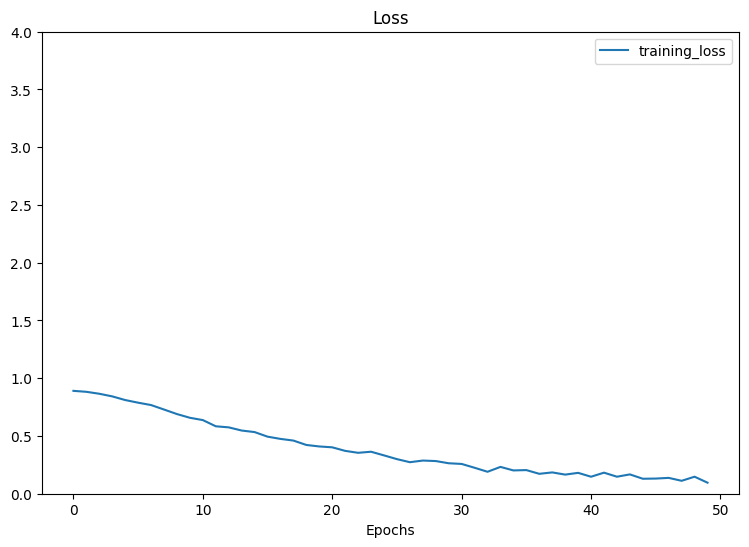

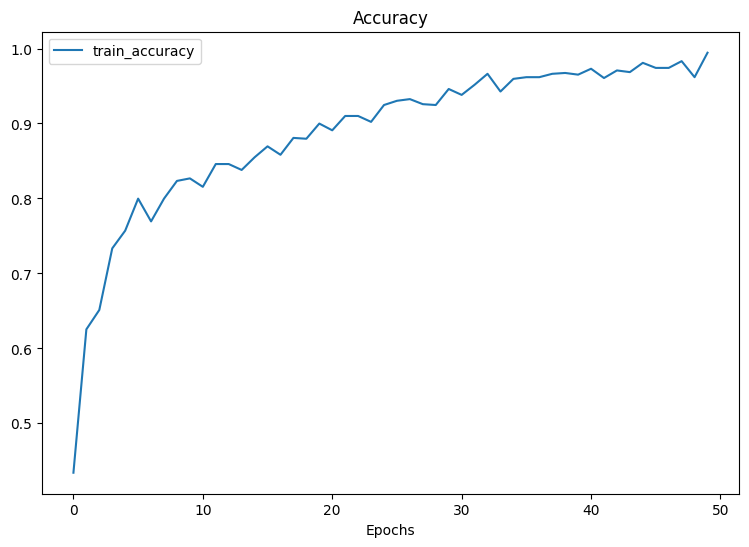

In [8]:
# --- Train the model with the best hyperparameters and evaluate it on the test set ---

# Hyperparameters
BEST_LR = 1e-5 # learning rate
BEST_WD= 1e-4 # weight decay
BEST_NUM_EPOCHS = 50 # number of epochs for training
cosine_scheduler = False # Set to True if using cosine decay, False if using fixed learning rate
print(f"Using cosine decay: {cosine_scheduler}")

train_for_more_epochs = False

# Filepath to save/load the model
SAVED_MODEL_FILEPATH = "/home/diogommiranda/tese/outputs/best_model.pth"

# Load saved model or train anew
if train_for_more_epochs:
    model.load_state_dict(torch.load(SAVED_MODEL_FILEPATH, weights_only=True, map_location=device)) # load model to continue training for more epochs
    print(f"\nLoading model weights to continue training for more epochs.")
else:
    model = ResNet(
        block='basic',
        layers=[3, 4, 6, 3],
        block_inplanes=[64, 128, 256, 512],
        spatial_dims=3,
        n_input_channels=1,
        conv1_t_stride=2,
        num_classes=1,
        shortcut_type='B',
        bias_downsample=False
    )
    model.to(device)

# Compute class weights
unique_classes, class_counts = np.unique(train_labels, return_counts=True)
print(f"  Train label counts: {dict(zip(unique_classes, class_counts))}")
pos_weight_val = class_counts[0] / class_counts[1]
pos_weight_val = torch.tensor([pos_weight_val], device=device)
print(f"  Calculated pos_weight for BCEWithLogitsLoss: {pos_weight_val.item():.4f}")

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight_val).to(device)

#optimizer = torch.optim.Adam(model.parameters(), lr=BEST_LR, weight_decay=BEST_WD)
optimizer = torch.optim.SGD(model.parameters(), lr=BEST_LR, weight_decay=BEST_WD, momentum=0.9, nesterov=True)

scheduler = None
if cosine_scheduler:
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100, eta_min=1e-7) # T_max=100 for 100 epochs (used in CV)

history = {'epoch': [], 'train_loss': [], 'train_accuracy': [], 'train_auc': []}

for epoch in tqdm(range(BEST_NUM_EPOCHS)):
    epoch_start_time = time.time()
    history['epoch'].append(epoch + 1)

    model.train()
    running_loss = 0.0
    train_pred_probs = []
    train_targets = []

    for i, (inputs, labels) in enumerate(train_data):
        inputs = inputs.to(device)
        labels = labels.float().unsqueeze(1).to(device)
        
        optimizer.zero_grad()
        
        # Mixed precision
        with torch.autocast(device_type=device.type, dtype=torch.float16, enabled=USE_AMP):
            outputs = model(inputs)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * inputs.size(0)
        
        prob_outputs = torch.sigmoid(outputs)
        train_pred_probs.extend(prob_outputs.detach().cpu().numpy())
        train_targets.extend(labels.detach().cpu().numpy())

    train_targets = np.array(train_targets).flatten()
    train_pred_probs = np.array(train_pred_probs).flatten()
    
    # Calculate training metrics for the epoch
    train_loss = running_loss / len(train_data.dataset)
    train_acc = accuracy_score(train_targets, train_pred_probs >= 0.5)
    train_auc = roc_auc_score(train_targets, train_pred_probs)
    history['train_loss'].append(train_loss)
    history['train_accuracy'].append(train_acc)
    history['train_auc'].append(train_auc)
        
    epoch_duration = time.time() - epoch_start_time
    print(f"    Epoch {epoch+1}/{BEST_NUM_EPOCHS} [{epoch_duration:.2f}s] - Train Loss: {train_loss:.5f}, Train Acc: {train_acc:.5f}")
    
    if scheduler:
        scheduler.step()

# Save the model if using fixed learning rate in case we want to continue training it
if not cosine_scheduler:
    torch.save(model.state_dict(), SAVED_MODEL_FILEPATH)
    print(f"Model saved to: {SAVED_MODEL_FILEPATH}")

plot_loss_curves(history)

# Evaluate the model on the test data
model.eval()
test_running_loss = 0.0
test_pred_probs = []
test_targets = []

with torch.inference_mode():
    for inputs, labels in test_data:
        inputs = inputs.to(device)
        labels = labels.float().unsqueeze(1).to(device)

        # Mixed precision
        with torch.autocast(device_type=device.type, dtype=torch.float16, enabled=USE_AMP):
            outputs = model(inputs)
            loss = criterion(outputs, labels)

        test_running_loss += loss.item() * inputs.size(0)
    
        prob_outputs = torch.sigmoid(outputs)
        
        test_pred_probs.extend(prob_outputs.cpu().numpy())
        test_targets.extend(labels.cpu().numpy())

test_targets = np.array(test_targets).flatten()
test_pred_probs = np.array(test_pred_probs).flatten()

# Calculate test loss and accuracy
test_loss = test_running_loss / len(test_data.dataset)
test_acc = accuracy_score(test_targets, test_pred_probs >= 0.5)
print(f"Test Loss: {test_loss}, Test Acc: {test_acc}")


--- Evaluation Metrics on Test Set ---
Accuracy:    0.8145
Sensitivity: 0.7179
Specificity: 0.8671 
Balanced Accuracy (BACC): 0.7925
F1 Score (Weighted):      0.8136
Matthews Corr Coef (MCC): 0.5905
Area Under the Curve (AUC): 0.7925



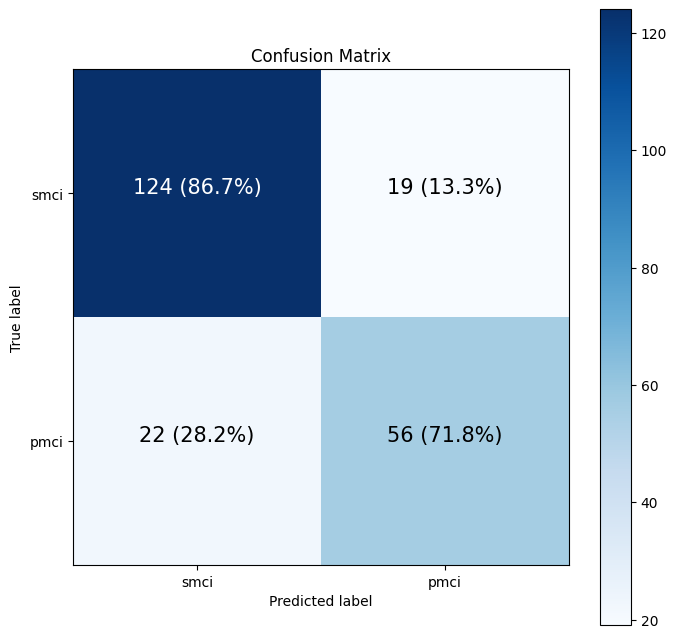

In [9]:
y_true = test_targets.astype(int)
y_pred = test_pred_probs.round().astype(int)

# Calculate metrics
accuracy = test_acc
sensitivity = recall_score(y_true, y_pred, pos_label=1)
specificity = recall_score(y_true, y_pred, pos_label=0)
bacc = balanced_accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='weighted')
mcc = matthews_corrcoef(y_true, y_pred)
auc_score = roc_auc_score(y_true, y_pred)

print("\n--- Evaluation Metrics on Test Set ---")
print(f"Accuracy:    {accuracy:.4f}")
print(f"Sensitivity: {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f} ")
print(f"Balanced Accuracy (BACC): {bacc:.4f}")
print(f"F1 Score (Weighted):      {f1:.4f}") 
print(f"Matthews Corr Coef (MCC): {mcc:.4f}")
print(f"Area Under the Curve (AUC): {auc_score:.4f}\n")

class0, class1 = DATASET.split("_")
target_names = [class0, class1]

make_confusion_matrix(y_true, y_pred, target_names, figsize=(8, 8), text_size=15)


# Save the model

In [10]:
save_option = True # Set to True to save the model, confusion matrix, and evaluation metrics

if save_option:
    
    # Configure the right path
    if USE_MASK:
        dir1 = "masked/"
    else:
        dir1 = "full_brain/"
    if cosine_scheduler:
        dir2 = "cosine_decay/"
    else:
        dir2 = "fixed_lr/"
        
    save_model_dir = "/home/diogommiranda/tese/outputs/torch/" + dir1 + dir2 + "CROSS_VALIDATION/saved_models/" + f"LRRR={BEST_LR:.1e}_WD={BEST_WD:.0e}"
    print(f"Saving model to: {save_model_dir}")
    os.makedirs(save_model_dir, exist_ok=True)

    # Save the model
    torch.save(model.state_dict(), os.path.join(save_model_dir, "model.pth"))

    # Save the confusion matrix plot
    make_confusion_matrix(y_true=y_true,
                        y_pred=y_pred.round(),
                        classes=target_names,
                        figsize=(8, 8),
                        text_size=15,
                        save_dir=save_model_dir)

    # Save the test loss and accuracy and the evaluation metrics
    result_file_path = os.path.join(save_model_dir, "resultados.txt")
    with open(result_file_path, "w") as f:
        f.write(f"[{test_loss}, {test_acc}]\n\n")
        f.write("--- Evaluation Metrics on Test Set ---\n")
        f.write(f"Accuracy:    {accuracy:.4f}\n")
        f.write(f"Sensitivity: {sensitivity:.4f}\n")
        f.write(f"Specificity: {specificity:.4f}\n")
        f.write(f"Balanced Accuracy (BACC): {bacc:.4f}\n")
        f.write(f"F1 Score (Weighted):      {f1:.4f}\n")
        f.write(f"Matthews Corr Coef (MCC): {mcc:.4f}\n")
        f.write(f"Area Under the Curve (AUC): {auc_score:.4f}\n")

Saving model to: /home/diogommiranda/tese/outputs/torch/full_brain/fixed_lr/CROSS_VALIDATION/saved_models/LRRR=1.0e-05_WD=1e-04


  Train label counts: {0: 575, 1: 314}
  Calculated pos_weight for BCEWithLogitsLoss: 1.8312
Test Loss: 0.7523062952638212, Test Acc: 0.8099547511312217

--- Evaluation Metrics on Test Set ---
Accuracy:    0.8100
Sensitivity: 0.7436
Specificity: 0.8462 
Balanced Accuracy (BACC): 0.7949
F1 Score (Weighted):      0.8105
Matthews Corr Coef (MCC): 0.5864
Area Under the Curve (AUC): 0.7949



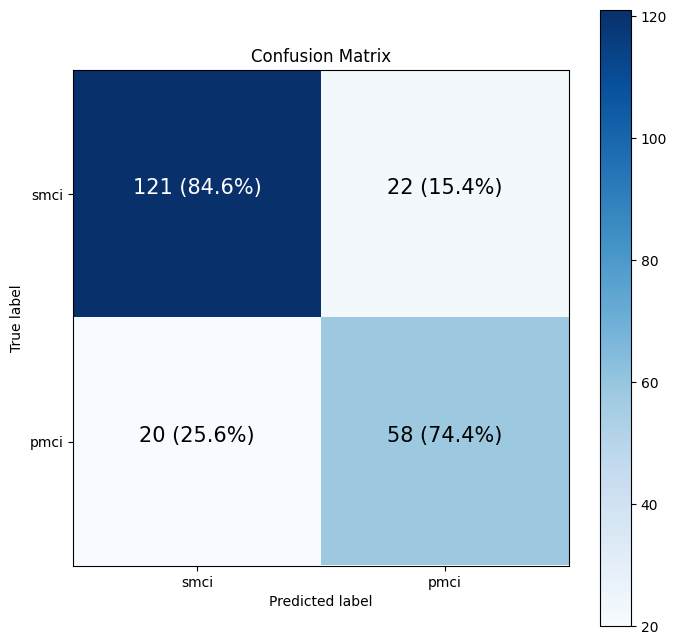

In [12]:
load_model = ResNet(
        block='basic',
        layers=[3, 4, 6, 3],
        block_inplanes=[64, 128, 256, 512],
        spatial_dims=3,
        n_input_channels=1,
        conv1_t_stride=2,
        num_classes=1,
        shortcut_type='B',
        bias_downsample=False
        )
load_model.to(device)
save_model_dir = "/home/diogommiranda/tese/outputs/torch/full_brain/fixed_lr/CROSS_VALIDATION/saved_models/LR=1.0e-05_WD=1e-04 (sgd)"
load_model.load_state_dict(torch.load(os.path.join(save_model_dir, "model.pth"), map_location=device))

# Compute class weights
unique_classes, class_counts = np.unique(train_labels, return_counts=True)
print(f"  Train label counts: {dict(zip(unique_classes, class_counts))}")
pos_weight_val = class_counts[0] / class_counts[1]
pos_weight_val = torch.tensor([pos_weight_val], device=device)
print(f"  Calculated pos_weight for BCEWithLogitsLoss: {pos_weight_val.item():.4f}")

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight_val).to(device)

# Evaluate the model on the test data
load_model.eval()
test_running_loss = 0.0
test_pred_probs = []
test_targets = []

with torch.inference_mode():
    for inputs, labels in test_data:
        inputs = inputs.to(device)
        labels = labels.float().unsqueeze(1).to(device)

        # Mixed precision
        with torch.autocast(device_type=device.type, dtype=torch.float16, enabled=USE_AMP):
            outputs = load_model(inputs)
            loss = criterion(outputs, labels)

        test_running_loss += loss.item() * inputs.size(0)
    
        prob_outputs = torch.sigmoid(outputs)
        
        test_pred_probs.extend(prob_outputs.cpu().numpy())
        test_targets.extend(labels.cpu().numpy())

test_targets = np.array(test_targets).flatten()
test_pred_probs = np.array(test_pred_probs).flatten()

# Calculate test loss and accuracy
test_loss = test_running_loss / len(test_data.dataset)
test_acc = accuracy_score(test_targets, test_pred_probs >= 0.5)
print(f"Test Loss: {test_loss}, Test Acc: {test_acc}")

y_true = test_targets.astype(int)
y_pred = test_pred_probs.round().astype(int)

# Calculate metrics
accuracy = test_acc
sensitivity = recall_score(y_true, y_pred, pos_label=1)
specificity = recall_score(y_true, y_pred, pos_label=0)
bacc = balanced_accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='weighted')
mcc = matthews_corrcoef(y_true, y_pred)
auc_score = roc_auc_score(y_true, y_pred)

print("\n--- Evaluation Metrics on Test Set ---")
print(f"Accuracy:    {accuracy:.4f}")
print(f"Sensitivity: {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f} ")
print(f"Balanced Accuracy (BACC): {bacc:.4f}")
print(f"F1 Score (Weighted):      {f1:.4f}") 
print(f"Matthews Corr Coef (MCC): {mcc:.4f}")
print(f"Area Under the Curve (AUC): {auc_score:.4f}\n")

class0, class1 = DATASET.split("_")
target_names = [class0, class1]

make_confusion_matrix(y_true, y_pred, target_names, figsize=(8, 8), text_size=15)
